# Neural Network From Scratch
This notebook shows how to build a small neural network without using ML libraries like sklearn or TensorFlow.

## Import Libraries

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

## 1️⃣ Generate Data
We create synthetic data where y = 2x + 3 + noise.

In [30]:
np.random.seed(42)
x = np.random.uniform(-5, 5, 200)
z = np.random.uniform(-5, 5, 200)
noise = np.random.normal(0, 1, 200)
y = 2 * x + 3 + noise
df = pd.DataFrame({'x': x, 'z': z, 'y': y})
df.head()

,x,z,y
0,-1.254599,1.420316,1.796281
1,4.507143,-4.158600,12.035290
2,2.319939,-3.383713,8.321832
3,0.986585,3.985542,4.662903
4,-3.439814,1.064291,-3.555461


## 2️⃣ Feature Engineering
We add extra features to help the model.

In [31]:
df['x2'] = df['x']**2
df['x3'] = df['x']**3
df['z2'] = df['z']**2
df['z3'] = df['z']**3
df['xz'] = df['x'] * df['z']
df['x_div_z'] = np.clip(df['x'] / (df['z'] + 1e-2), -10, 10)
df['log1p_x'] = np.log1p(np.abs(df['x']))
df['sqrt_x'] = np.sqrt(np.abs(df['x']))
df['sin_x'] = np.sin(df['x'])
df['cos_z'] = np.cos(df['z'])
df['z_bin'] = pd.qcut(df['z'], 4, labels=False)
df = pd.get_dummies(df, columns=['z_bin'])
a = np.random.normal(0, 1, 200)
df['a'] = a
df['a2'] = a**2
df['a3'] = a**3
df['sina'] = np.sin(a)
df['cosa'] = np.cos(a)
df['log1p_a'] = np.log1p(np.abs(a))
df['sqrt_a'] = np.sqrt(np.abs(a))

## 3️⃣ Split Data
We split the data into train, validation, and test sets.

In [32]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['y']).values.astype(np.float64)
y = df['y'].values.reshape(-1, 1).astype(np.float64)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [33]:

class MiniNN:
    def __init__(self, input_dim, hidden_dim=5, l2=0.0, l1=0.0):
        self.W1 = np.random.randn(input_dim, hidden_dim) * 0.01
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = np.random.randn(hidden_dim, 1) * 0.01
        self.b2 = np.zeros((1, 1))
        self.l2 = l2
        self.l1 = l1
        self.v_W1 = np.zeros_like(self.W1)
        self.v_W2 = np.zeros_like(self.W2)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_deriv(self, x):
        return (x > 0).astype(float)

    def forward(self, X):
        self.Z1 = X @ self.W1 + self.b1
        self.A1 = self.relu(self.Z1)
        self.Z2 = self.A1 @ self.W2 + self.b2
        return self.Z2

    def compute_loss(self, y_pred, y_true):
        mse = np.mean((y_pred - y_true) ** 2)
        reg = self.l2 * (np.sum(self.W1 ** 2) + np.sum(self.W2 ** 2)) +               self.l1 * (np.sum(np.abs(self.W1)) + np.sum(np.abs(self.W2)))
        return mse + reg

    def backward(self, X, y_true, y_pred):
        m = X.shape[0]
        dZ2 = 2 * (y_pred - y_true) / m
        dW2 = self.A1.T @ dZ2 + self.l2 * 2 * self.W2 + self.l1 * np.sign(self.W2)
        db2 = np.sum(dZ2, axis=0, keepdims=True)
        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * self.relu_deriv(self.Z1)
        dW1 = X.T @ dZ1 + self.l2 * 2 * self.W1 + self.l1 * np.sign(self.W1)
        db1 = np.sum(dZ1, axis=0, keepdims=True)
        return dW1, db1, dW2, db2

    def update_weights(self, dW1, db1, dW2, db2, lr, momentum):
        self.v_W1 = momentum * self.v_W1 - lr * dW1
        self.v_W2 = momentum * self.v_W2 - lr * dW2
        self.W1 += self.v_W1
        self.W2 += self.v_W2
        self.b1 -= lr * db1
        self.b2 -= lr * db2


## 4️ Training Function
We train the model using batch gradient descent with momentum and learning rate decay.


In [34]:
def train_model(X_train, y_train, X_val, y_val, params):
    model = MiniNN(X_train.shape[1], l2=params['l2'], l1=params['l1'])
    best_val_loss = float('inf')
    best_model = None
    patience = 0
    train_losses, val_losses = [], []
    lr = params['lr']
    batch_size = params['batch_size']

    for epoch in range(200):
        idx = np.random.permutation(len(X_train))
        X_train, y_train = X_train[idx], y_train[idx]

        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            y_pred = model.forward(X_batch)
                # check for NaN to prevent crash
            if np.isnan(y_pred).any():
              print("NaN detected in predictions — stopping early.")
              return model, [np.inf], [np.inf]  # to avoid empty lists


            dW1, db1, dW2, db2 = model.backward(X_batch, y_batch, y_pred)
            model.update_weights(dW1, db1, dW2, db2, lr, params['momentum'])

        # compute train and val loss
        train_pred = model.forward(X_train)
        val_pred = model.forward(X_val)
        train_loss = model.compute_loss(train_pred, y_train)
        val_loss = model.compute_loss(val_pred, y_val)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # check improvement
        if val_loss + 1e-6 < best_val_loss:
            best_val_loss = val_loss
            best_model = model
            patience = 0
        else:
            patience += 1
            if patience >= 10:
                lr *= 0.5  # reduce learning rate
            if patience >= 20:
                break  # early stopping

    if best_model is None:
        best_model = model  # fallback

    return best_model, train_losses, val_losses


## 5️⃣ Grid Search
Try different combinations of hyperparameters to find the best model.


In [35]:
configs = []
results = []

for lr in [1e-2, 1e-3]:
    for mom in [0.5, 0.9]:
        for l2 in [0, 0.01]:
            for l1 in [0, 0.01]:
                for batch in  [5, len(X_train)]:
                    config = {'lr': lr, 'momentum': mom, 'l2': l2, 'l1': l1, 'batch_size': batch}
                    model, train_loss, val_loss = train_model(X_train, y_train, X_val, y_val, config)
                    final_val = val_loss[-1] if len(val_loss) > 0 else np.inf
                    configs.append(config)
                    results.append((model, train_loss, val_loss, final_val))


/tmp/ipython-input-33-3836382564.py:32: RuntimeWarning: overflow encountered in matmul
  dW2 = self.A1.T @ dZ2 + self.l2 * 2 * self.W2 + self.l1 * np.sign(self.W2)
/tmp/ipython-input-33-3836382564.py:34: RuntimeWarning: overflow encountered in matmul
  dA1 = dZ2 @ self.W2.T
/tmp/ipython-input-33-3836382564.py:36: RuntimeWarning: invalid value encountered in matmul
  dW1 = X.T @ dZ1 + self.l2 * 2 * self.W1 + self.l1 * np.sign(self.W1)
/tmp/ipython-input-33-3836382564.py:19: RuntimeWarning: invalid value encountered in matmul
  self.Z1 = X @ self.W1 + self.b1
/tmp/ipython-input-33-3836382564.py:25: RuntimeWarning: overflow encountered in square
  mse = np.mean((y_pred - y_true) ** 2)
/tmp/ipython-input-33-3836382564.py:21: RuntimeWarning: overflow encountered in matmul
  self.Z2 = self.A1 @ self.W2 + self.b2
/tmp/ipython-input-33-3836382564.py:32: RuntimeWarning: invalid value encountered in matmul
  dW2 = self.A1.T @ dZ2 + self.l2 * 2 * self.W2 + self.l1 * np.sign(self.W2)
/tmp/ipython-

NaN detected in predictions — stopping early.
NaN detected in predictions — stopping early.
NaN detected in predictions — stopping early.
NaN detected in predictions — stopping early.
NaN detected in predictions — stopping early.
NaN detected in predictions — stopping early.
NaN detected in predictions — stopping early.
NaN detected in predictions — stopping early.
NaN detected in predictions — stopping early.
NaN detected in predictions — stopping early.
NaN detected in predictions — stopping early.
NaN detected in predictions — stopping early.
NaN detected in predictions — stopping early.
NaN detected in predictions — stopping early.
NaN detected in predictions — stopping early.
NaN detected in predictions — stopping early.
NaN detected in predictions — stopping early.
NaN detected in predictions — stopping early.
NaN detected in predictions — stopping early.
NaN detected in predictions — stopping early.
NaN detected in predictions — stopping early.
NaN detected in predictions — stop

## 6️⃣ Evaluation
Show the best config and evaluate it using MSE, MAE, and RMSE.


In [36]:
best_idx = np.argmin([r[-1] for r in results])
best_model, train_loss, val_loss, _ = results[best_idx]
y_test_pred = best_model.forward(X_test)

# check for NaNs or infs
print("Any NaN:", np.isnan(y_test_pred).any())
print("Any Inf:", np.isinf(y_test_pred).any())
print("Max:", np.max(y_test_pred))
print("Min:", np.min(y_test_pred))

mse = np.mean((y_test_pred - y_test) ** 2)
mae = np.mean(np.abs(y_test_pred - y_test))
rmse = np.sqrt(mse)

print("Best Config:", configs[best_idx])
print("Test MSE:", mse)
print("Test MAE:", mae)
print("Test RMSE:", rmse)


Any NaN: False
Any Inf: False
Max: 14.127190695313356
Min: -7.793725010002645
Best Config: {'lr': 0.001, 'momentum': 0.5, 'l2': 0.01, 'l1': 0.01, 'batch_size': 5}
Test MSE: 1.641681448892261
Test MAE: 1.052707310373518
Test RMSE: 1.2812811747982022


## 7️⃣ Plotting (from me)
Plot loss curves and validation loss per configuration.



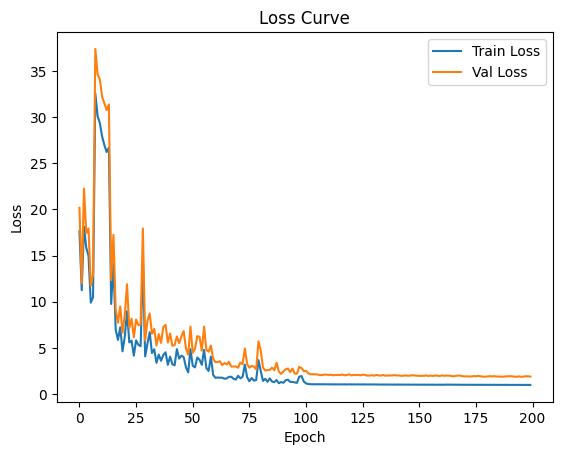

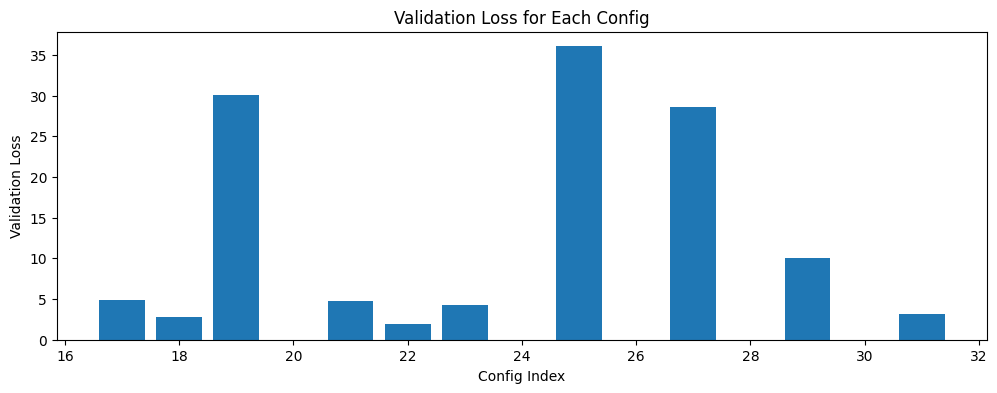

In [37]:
# Loss curve
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Validation score per config
val_scores = [r[-1] for r in results]
plt.figure(figsize=(12, 4))
plt.bar(range(len(val_scores)), val_scores)
plt.title("Validation Loss for Each Config")
plt.xlabel("Config Index")
plt.ylabel("Validation Loss")
plt.show()


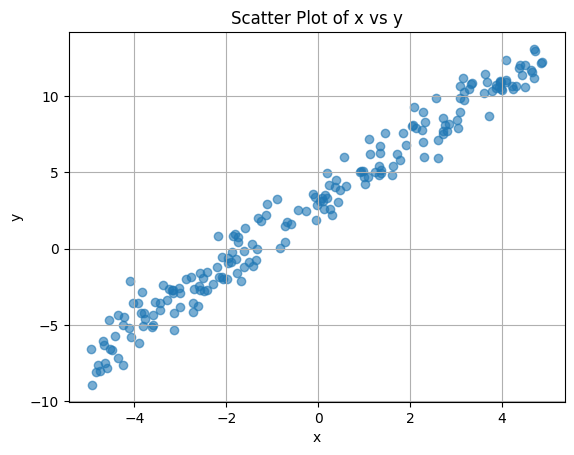

In [38]:
# This scatter plot shows the relationship between the feature 'x' and the target 'y'.
# Since y = 2x + 3 + noise, we expect to see a linear trend.

import matplotlib.pyplot as plt

plt.scatter(df['x'], df['y'], alpha=0.6)
plt.title("Scatter Plot of x vs y")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()


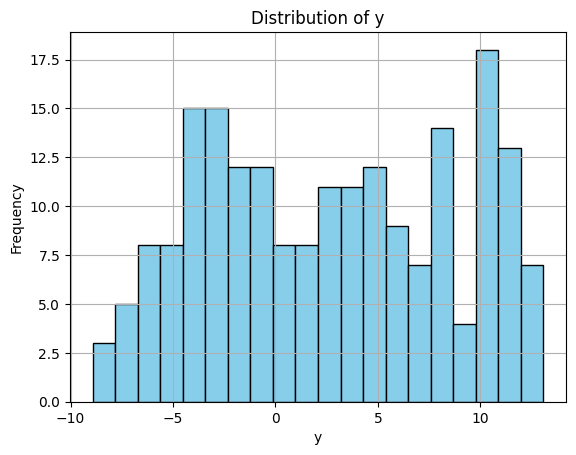

In [39]:
# This histogram shows the distribution of the target variable 'y'.
# It helps to check if 'y' is normally distributed or skewed.

plt.hist(df['y'], bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of y")
plt.xlabel("y")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


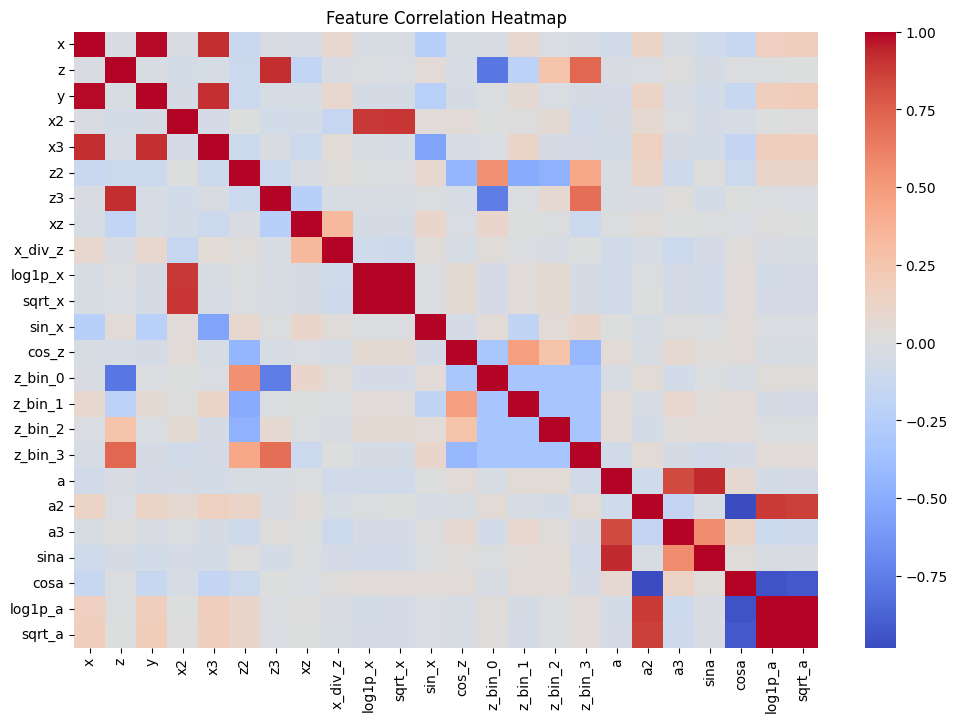

In [40]:
# This heatmap shows the correlation between all features.
# Useful to detect highly correlated features or redundancy.

import seaborn as sns

corr = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()
